# Unsupervised learning

Objectives:
- operate a PCA using Scikit-learn
- apply k-means on a color compression problem and exploit the prototype

In [ ]:
# imports
from sklearn import datasets
import skimage.color
import matplotlib.pyplot as plt
import numpy as np

# Learning representations with PCA

## Principal component analysis

The principal component analysis (PCA) is one of the first tool to be used for data analysis.
In this practical session, our objective is to analysis how similar are handwritten digits.

We will use the small digits dataset provided by Scikit-learn. Images are 8x8 pixels.

<font color='red'>Question</font>: run the following cell to observe the type of data.

(1797, 64)


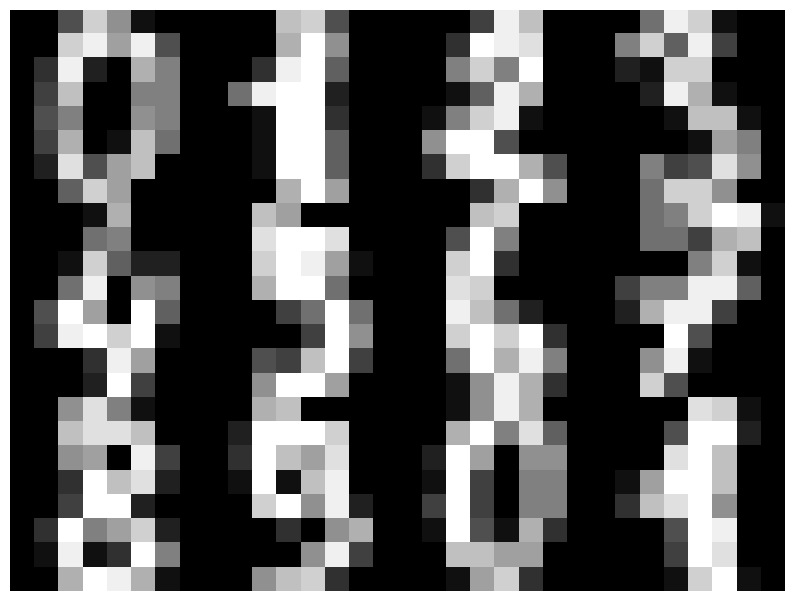

In [ ]:
# Load data
dataset = datasets.load_digits()
data = dataset["data"]
labels = dataset["target"]

# print the dataset shape
print(data.shape)

# Print several sample data

width=8
height = 8
ncols = 4

nsample = ncols*3

nrows= nsample // ncols

fig = plt.figure(figsize=(10, 10))
img_grid = (data[:nsample,:].reshape(nrows, ncols, height, width)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols))
plt.imshow(img_grid, cmap='gray')
plt.axis('off')
plt.show()


### PCA fitting

<font color='red'>Question</font>: Use the documentation of PCA class from Scikit-learn [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to create a PCA object, with 16 components.

<font color='red'>Question</font>: "fit" on the data.

<font color='red'>Question</font>: Read the documentation and find the variable containing the components. Show the components using the code for displaying several images on a grid (previous cell).

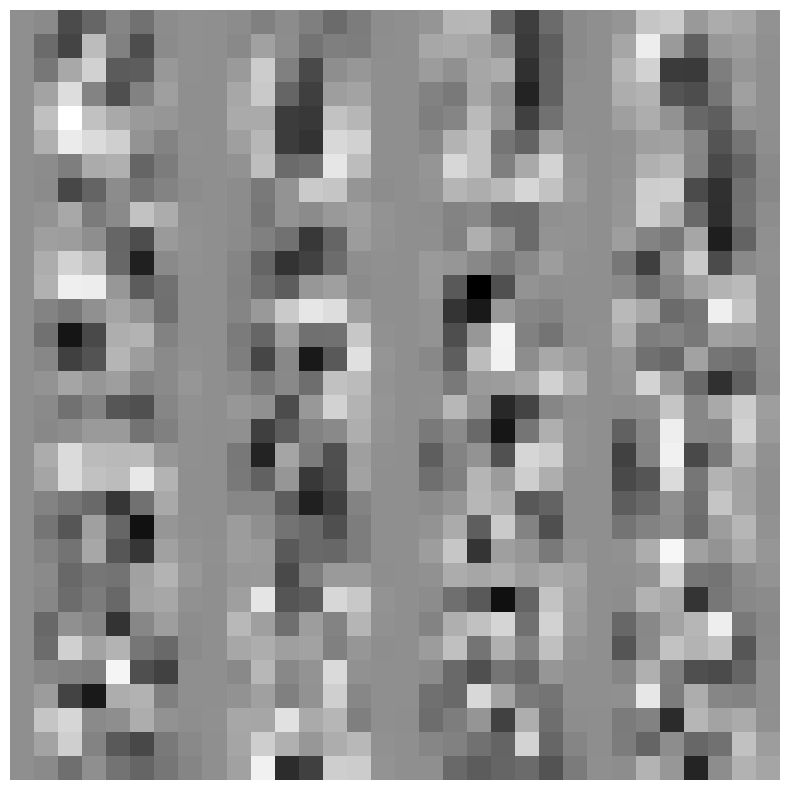

In [ ]:
from sklearn import decomposition
ncomponent = 16

### Put your code here

pca = decomposition.PCA(ncomponent)
pca.fit(data)

def image_grid(array, ncols=4):
    index, height, width, channels = array.shape
    nrows = index//ncols

    img_grid = (array.reshape(nrows, ncols, height, width, channels)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols))

    return img_grid

width=8
height = 8
ncols = 4
nrows= ncomponent // ncols

fig = plt.figure(figsize=(10, 10))
img_grid = (pca.components_.reshape(nrows, ncols, height, width)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols))
plt.imshow(img_grid, cmap='gray')
plt.axis('off')
plt.show()

## Visualization

<font color='red'>Question</font>: apply transformation on the data itself.

<font color='red'>Question</font>: Visualize the data with `plt.scatter` on the first two components. Use the labels as color indication (`c` parameter of the `scatter` function).

<font color='red'>Question</font>: Discuss the visualization.

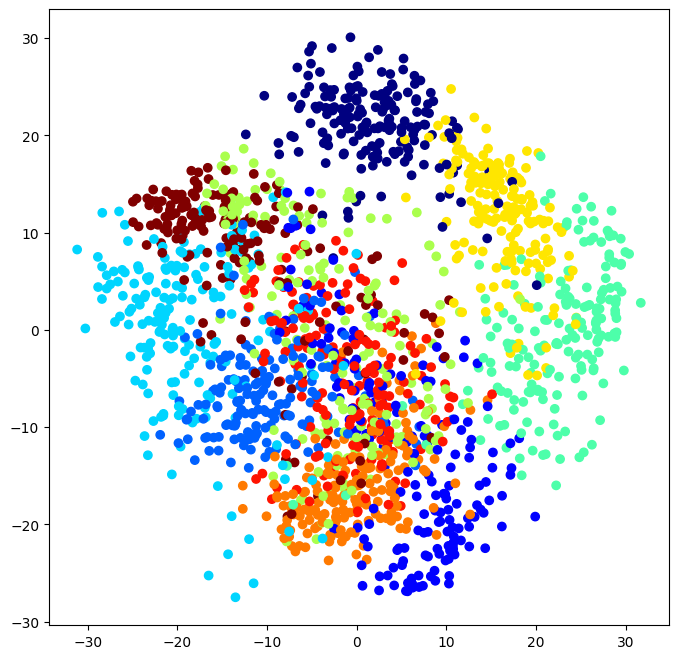

In [ ]:
# project data on the two first components
pred = pca.transform(data)

# plot the points
plt.figure(figsize=(8,8))
plt.scatter(pred[:,0], pred[:,1], c=labels, cmap="jet")

We have seen another algorithm for visualizing data: t-SNE.

<font color='red'>Question</font>: Use [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to visualize the same data and find a good perplexity.

A good discussion of the impact of t-SNE parameters can be found [here](https://distill.pub/2016/misread-tsne/).

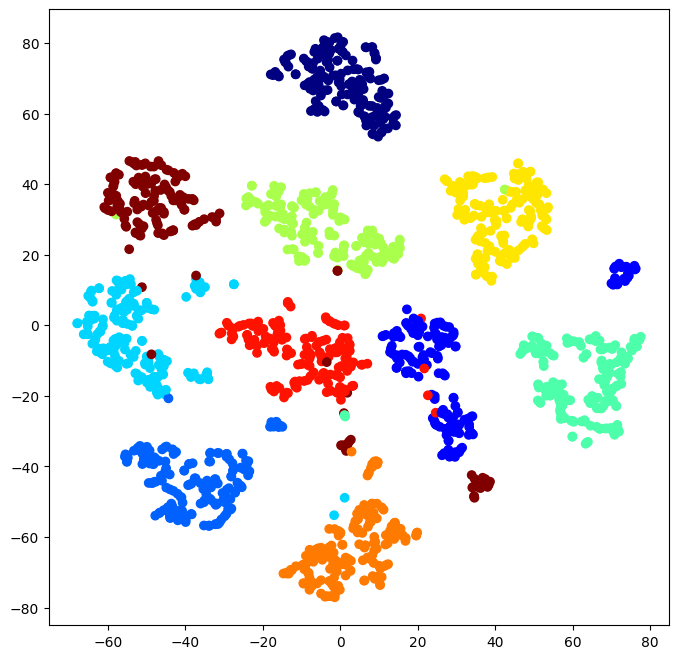

In [ ]:
from sklearn.manifold import TSNE

### Put your code here
X_tsne = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=10, n_jobs=-1).fit_transform(data)

# plot the points
plt.figure(figsize=(8,8))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=labels, cmap="jet")


## Denoising

We want to use PCA to denoise data. The principle is to projet the data on the principle components and generate the data back by linear combination of the data.

You cnan use the `transform` and ìnverse_transform` of the PCA class of scikit-learn or the reconstruction formula $PP^T.(X-\bar{X})+\bar{X}$ where $P$ is the projection matrix on the components and $\bar{X}$ the data mean.

<font color='red'>Question</font>: use the function  to implement this denoising strategy and show the results on the corrupted data below.

<font color='red'>Question</font>: test several number of components and observe the impact on the reconstruction quality.

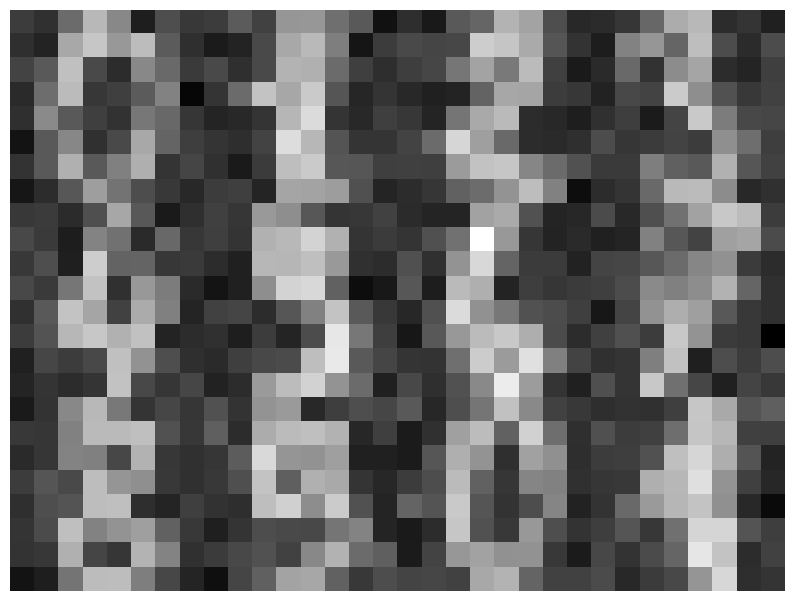

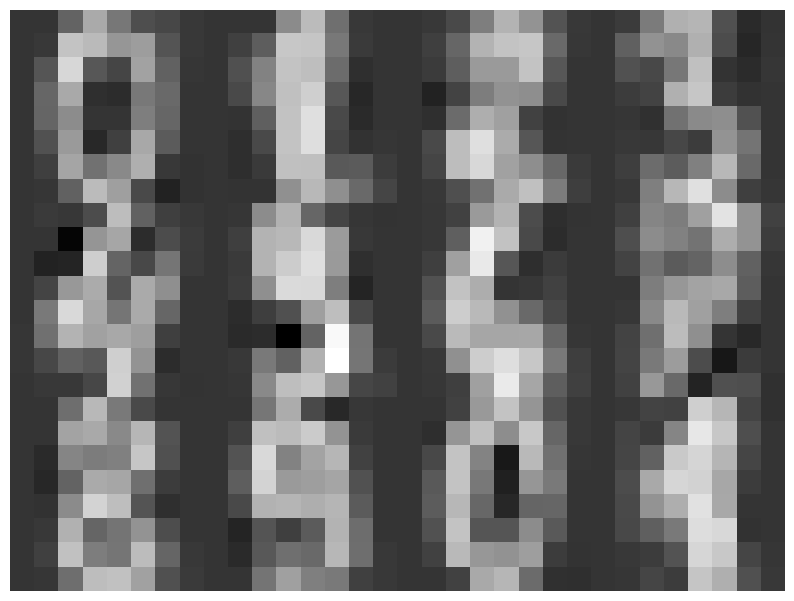

In [ ]:
# Corrupted data
ns = np.random.normal(0,2, data.shape)
noised = data + ns

# Display corrupted samples

width=8
height = 8
ncols = 4

nsample = ncols*3

nrows= nsample // ncols

fig = plt.figure(figsize=(10, 10))
img_grid = (noised[:nsample,:].reshape(nrows, ncols, height, width)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols))
plt.imshow(img_grid, cmap='gray')
plt.axis('off')
plt.show()

####### Put your code here

data_pca = pca.transform(noised)
filtered = pca.inverse_transform(data_pca)

filtered2 = (noised - pca.mean_) @ pca.components_.T @ pca.components_ + pca.mean_

#########

fig = plt.figure(figsize=(10, 10))
img_grid = (filtered[:nsample,:].reshape(nrows, ncols, height, width)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols))
plt.imshow(img_grid, cmap='gray')
plt.axis('off')
plt.show()


# Clustering

## Color compression

In this section, we want to apply clustering to encode the color pixels of an image. The idea is to replace each RGB pixel by a code that represents the prototype. To decode the image we simply replace the code by its prototype for each pixel in the *codebook*.

Considering that colors are usually coded with 3 bytes (8 bits, values in \[0, 255\]), an image without compression can be represented with: $3 \times N \times 8$ bits, where $N$ is the number of pixels.

If we now use $K=16$ clusters, the id of the clusters is coded on 4 bits and we need $K \times 3 \times 8$ bits to code the prototypes. Then our image size is:
$3 \times 8 \times K + 4 \times N$.

In practice the number of pixels is much larger than the number of prototypes, and the compression rate is:
$$ \frac{3 \times N \times 8}{3 \times 8 \times K + 4 \times N} \approx 6 $$

Other compression methods (JPEG, PNG) can do much better but rely on very different signal compression approaches.

<font color='red'>Question</font>: Load a sample image from https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_sample_image.html, and display it.

(427, 640, 3)


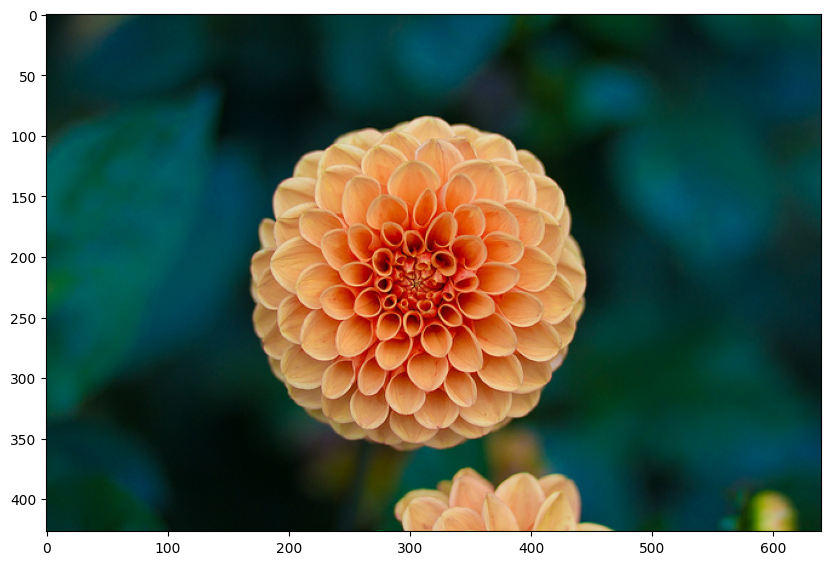

In [ ]:
# get the image and display it
image = datasets.load_sample_image("flower.jpg")
print(image.shape)

plt.figure(figsize=(10,15))
plt.imshow(image)


## K-means

We will use the kmeans function from scikitlearn as a clustering algorithm.
Its goal is to compute the codebook that replaces each pixel value by the centroid number of the cluster (i.e. the code).

The following decodes the encoded image (`labels`) using the codebook.

<font color='red'>Question</font>: read the code and understand it.

In [ ]:
# create the decoded image from the image of codes and the codebook
def decode(codes, codebook):
  compressed_image = np.zeros((codes.shape[0],codes.shape[1],len(codebook[0])))
  for i in range(len(codebook)):
      mask = (codes==i)
      compressed_image[mask] = codebook[i]
  return compressed_image.astype(np.uint8)


<font color='red'>Question</font>: Write the code that generates the codebook, the encoded and the decoded images using k-means. The size of the code is 16.

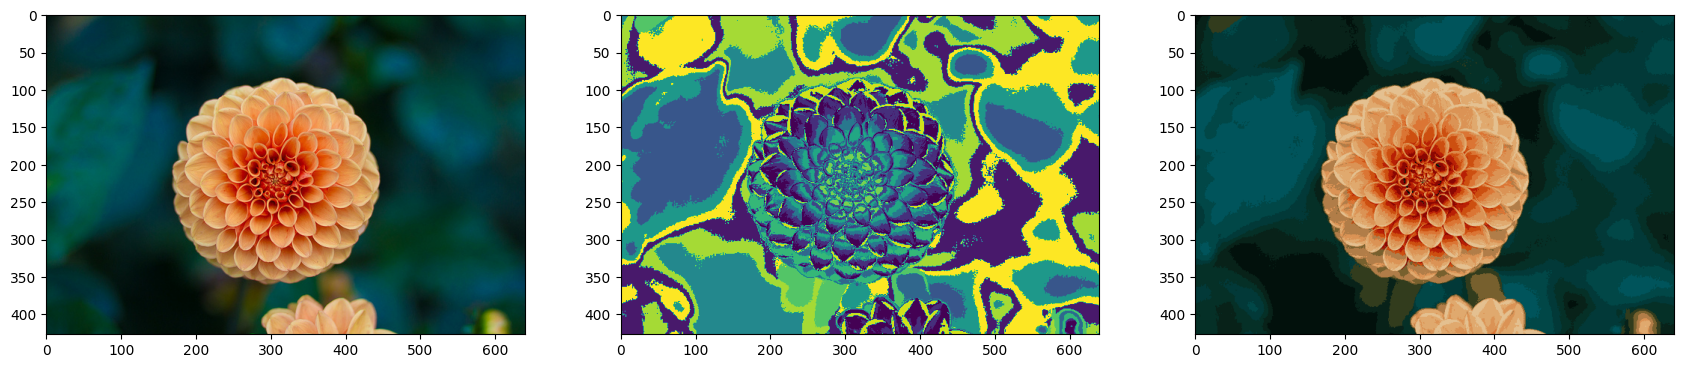

In [ ]:
from sklearn.cluster import KMeans

code_size = 16
################
# Put your code here
clustering = KMeans(n_clusters= code_size, random_state=0, n_init="auto").fit(image.reshape(-1, image.shape[-1]))
codebook = clustering.cluster_centers_

encoded_image = clustering.predict(image.reshape(-1, image.shape[-1])).reshape(image.shape[0],image.shape[1])
decoded_image = decode(encoded_image,codebook)

###################

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(21,14))
ax1.imshow(image)
ax2.imshow(encoded_image)
ax3.imshow(decoded_image)


## Segmentation

In this section we propose to use the image encoding to segment an image. This is a simple but effective strategy when the object foreground is visually different from the background. Grouping the pixels makes the definition of the background easy.

The following code displays the colormap that associate each code to a color.

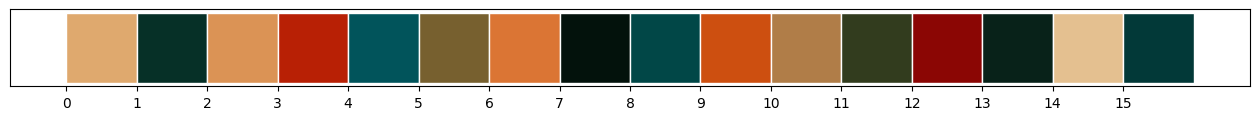

In [ ]:
## Code for displaying colormap
fig, ax = plt.subplots(1,1, figsize=(len(codebook),1))
for x, cc in enumerate(codebook):
  color = cc/256
  rect = plt.Rectangle([x, 0], 1, 1,
                             facecolor=color, edgecolor='white')
  ax.add_patch(rect)

ax.autoscale_view()
ax.set_xticks(np.arange(len(codebook)))
ax.set_yticks([])
plt.show()

The idea is to use this color encoding to segment the flower at the center of the image by changing to another color the background colors from the codebook.

<font color='red'>Question</font>: select the background color indices and display a new image where the background is in the same color (green or black).

(-0.5, 639.5, 426.5, -0.5)

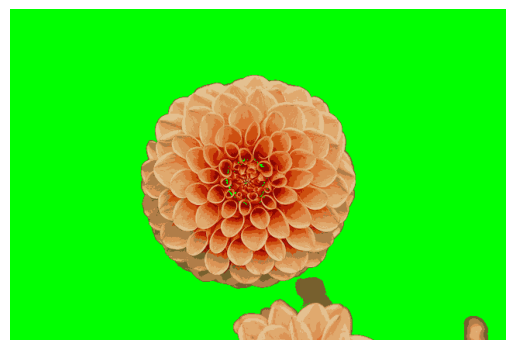

In [ ]:
# Put your code here
seg = clustering.cluster_centers_.copy()
blk_id = [1,4,7,8,11,13,15]
seg[blk_id,:]=[0,255,0]
segmented_image = decode(encoded_image,seg)

plt.imshow(segmented_image)
plt.axis('off')